# QB- Train and Evaluation
## Objective:
This notebook ment to tackle QB with the below descriptions:
- Generate an ML model for estimating the " `total_amount` " based on the variables (as input to the model):  `VendorID` ,`passenger_count`  ,`payment_type` , `trip_distance` 
- It is possible to independently define the methodology and the selection and split process of the reference dataset for training, testing and verification of the model (kf, random, train-test- valid )
- (optional) For model optimization it is recommended to calculate the RMSE on the selected partial test dataset
- Export the generated model to file (ie via pickle, json …)
- The quality assessment of the generated model will be verified through the calculation of the RMSE on a test dataset equivalent to the one used by the user in terms of format and compatible in terms of number (but not provided)
- The user is given the right to use a different ML model from those present in the sklearn libraries, but the generated model must be exportable, and the user must indicate the name and version of the library used (for calculation of the RMSE on the new test dataset)

Objective:
In this notebook the user implement a workflow for training and evaluation the model based on the preprocessed dataset. The user will be track and monitor the processes using `mlflow` tool during training and evaluating the model. The task is a regression problem which can be trained on different ML model from `scikit-learn` library including:
- `LinearRegression`
- `RandomForestRegressor`
- `GradientBoostingRegressor`

During the training, the user leverage k-fold cross validation technique to avoid possible overfiting and stabelize the estimator. These estimators will be evaluate using root mean squared error metric as a candidate metric for regression task. Finally, all the process will be tracked by `mlflow`.

The cell below will be execute the preprocessing step on the dataset. for more information please check [Preprocessing.ipynb](./Preprocessing.ipynb)

2024-07-09 23:19:08.995 | INFO     | taxi.utils.utils:read_yaml:29 - yaml file: config.yaml loaded successfully
2024-07-09 23:19:09.002 | INFO     | taxi.utils.utils:read_yaml:29 - yaml file: params.yaml loaded successfully


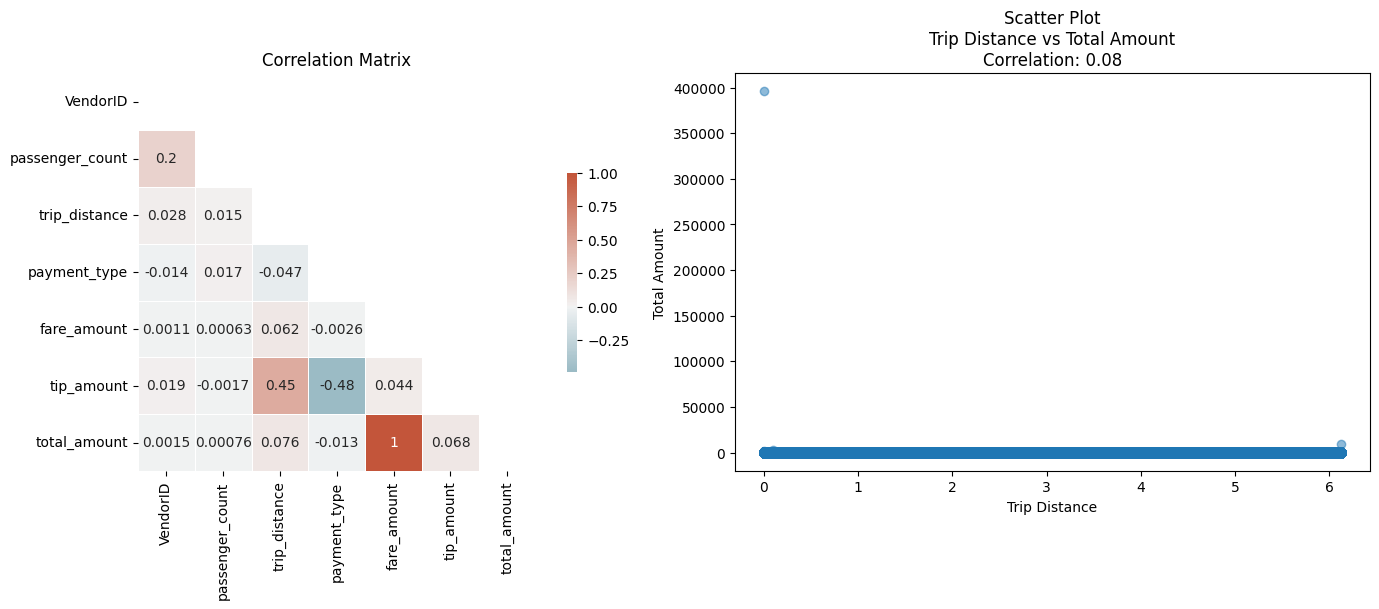

In [1]:
%run ./Preprocessing.ipynb

In [2]:
from sklearn.ensemble import RandomForestRegressor as skRFR
from sklearn.linear_model import LinearRegression as skLR
from sklearn.ensemble import GradientBoostingRegressor as skXGR
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
import pickle
import os
import subprocess
import time
import requests
from loguru import logger
import mlflow
from urllib.parse import urljoin, urlparse
import matplotlib.pyplot as plt
import json

The user define a `Model` class to implement a sort of function with the below discriptions:
- `is_mlflow_server_running`: A method to check if mlflow server is running or not.
- `start_mlflow_server`: A method to start the mlflow server if it is not started yet.
- `linear_regression_model`: A method to initiate a `Linear Regression` model.
- `random_forest_regression_model`: A method to initiate a `RandomForestRegressor` model.
- `gradient_boost_regression`: A method to initiate a `GradientBoostingRegressor` model.
- `training`: A method to train some estimators using k-fold cross validation technique.
- `evaluation`: A method to evaluate a set of estimator and calculate `RMSE`(root mean squared error). Subsequently, get the best model based on this evaluation metric. 
- `save_and_log_model`: A method to log input parameters, metrics, and model using `mlflow`. Additionally save the best estimators in to [arifacts/models](../../artifacts/models/)

In [3]:
class Model:
    def __init__(self, config, params, x__train, y__train, x__test, y__test) -> None:
        self.config = config
        self.params = params
        self.X_train = x__train
        self.y_train = y__train
        self.X_test = x__test
        self.y_test = y__test

    @staticmethod
    def is_mlflow_server_running():
        """Check if the MLflow server is running by sending a request to the tracking URI."""
        url = "http://127.0.0.1:5000"
        try:
            response = requests.get(url)
            return response.status_code == 200
        except requests.ConnectionError:
            return False

    def start_mlflow_server(self):
        """Start the MLflow server if it is not already running."""
        if not self.is_mlflow_server_running():
            print("MLflow server is not running. Starting the server...")
            process = subprocess.Popen(
                [
                    "mlflow",
                    "server",
                    "--backend-store-uri",
                    "sqlite:///mlflow.db",
                    "--default-artifact-root",
                    "./mlruns",
                    "--host",
                    "127.0.0.1",
                    "--port",
                    "5000",
                ]
            )
            logger.info("Waiting for the MLflow server to start...")
            time.sleep(5)  # Give the server some time to start
            if self.is_mlflow_server_running():
                print("MLflow server started successfully.")
            else:
                print("Failed to start the MLflow server.")
        else:
            print("MLflow server is already running.")

    def linear_regression_model(self):
        params = self.params.Models.LinearRegressionModel.HYPERPARAMETERS
        self.model = skLR(**params)

    def random_forest_regression_model(self):
        params = self.params.Models.RandomForestModel.HYPERPARAMETERS
        self.model = skRFR(**params)

    def gradient_boost_regression(self):
        params = self.params.Models.XGBoostModel.HYPERPARAMETERS
        self.model = skXGR(**params)

    def training(self, folds=3):
        kf = KFold(folds)
        kf.get_n_splits(self.X_train)
        score = 0.0
        models = []
        for trainIdx, validIdx in kf.split(self.X_train):
            X_train_valid, X_valid = (
                self.X_train.iloc[trainIdx],
                self.X_train.iloc[validIdx],
            )
            y_train_valid, y_test_valid = self.y_train[trainIdx], self.y_train[validIdx]
            self.model.fit(X_train_valid, y_train_valid)
            score = self.model.score(X_valid, y_test_valid)
            print("score = ", score)
            models.append(self.model)
        return models

    def evaluation(self, estimators):
        estimator_idx = 0
        self.best_estimator_rmse = float("inf")
        for estimator in estimators:
            estimator_idx = estimator_idx + 1
            y_test_pred = estimator.predict(self.X_test)
            rmse = root_mean_squared_error(self.y_test, y_test_pred)

            if rmse < self.best_estimator_rmse:
                self.best_estimator_rmse = rmse
                self.best_model = estimator
            logger.info(
                f"\nestimator_idx: {estimator_idx}, current_estimator_rmse: {rmse},best_estimator_rmse: {self.best_estimator_rmse}"
            )

        print(f"Best RMSE: {self.best_estimator_rmse:.4f}")

    def save_and_log_model(self, model_path, model_file, model_name):
        mlflow.sklearn.autolog(
            log_input_examples=False,
            log_model_signatures=True,
            log_models=True,
            log_datasets=True,
            log_post_training_metrics=True,
            serialization_format="cloudpickle",
            registered_model_name=f"{model_name}",
            pos_label=None,
            extra_tags=None,
        )
        mlflow.log_metric("RMSE", self.best_estimator_rmse)

        # Log the model
        mlflow.sklearn.log_model(self.best_model, f"{model_name}")
        # Save model also in a seprate file
        if not os.path.exists(f"{model_path}"):
            os.makedirs(f"{model_path}", exist_ok=True)
            with open(model_path + "/" + model_file, "wb") as file:
                pickle.dump(self.model, file)

The user defines a pipeline to train and evaluate different models including:
- `LinearRegression`
- `RandomForestRegressor`
- `GradientBoostingRegressor`

 the hyperparameters of the models can be defined via [`params.yaml`](../../params.yaml)

In [5]:
model_obj = Model(
    config=CONFIG,
    params=PARAMS,
    x__train=X_train,
    y__train=y_train,
    x__test=X_test,
    y__test=y_test,
)
for model_name in PARAMS.Models:
    model_obj.start_mlflow_server()
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    tracking_url_type_store = urlparse("http://127.0.0.1:5000").scheme
    mlflow.set_experiment("Taxi_Fare")
    with mlflow.start_run() as run:
        # print(mlflow.active_run().info,'\n', mlflow.run.info)

        if model_name == "LinearRegressionModel":
            model_obj.linear_regression_model()
        if model_name == "RandomForestModel":
            model_obj.random_forest_regression_model()
        if model_name == "XGBoostModel":
            model_obj.gradient_boost_regression()

        estimators = model_obj.training()
        model_obj.evaluation(estimators)

        model_obj.save_and_log_model(
            model_path=f"{CONFIG.Model.MODEL_PATH}/{model_name}/",
            model_file=f"{CONFIG.Model.MODEL_FILE}",
            model_name=model_name,
        )
        mlflow.end_run()

MLflow server is already running.


2024/07/09 23:23:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3.10/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/07/09 23:23:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3

score =  0.5046262881847211


2024/07/09 23:23:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3.10/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/07/09 23:23:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3

score =  0.5546037925414833


2024/07/09 23:23:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3.10/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/07/09 23:23:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3

score =  0.517554769538968


2024/07/09 23:23:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3.10/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024-07-09 23:23:23.388 | INFO     | __main__:evaluation:87 - 
estimator_idx: 1, current_estimator_rmse: 0.09347545605982038,best_estimator_rms

Best RMSE: 0.0935


2024/07/09 23:23:25 WARNING mlflow.utils.validation: Tag value '[{"run_id": "a73e6507a37c45e0bd74b44a84c1e00b", "artifact_path": "model", "utc_time_created": "2024-...' (5187 characters) is truncated to 5000 characters to meet the length limit.


MLflow server is already running.


2024/07/09 23:23:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3.10/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/07/09 23:23:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3

score =  0.511206706290005


2024/07/09 23:23:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3.10/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/07/09 23:23:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3

score =  0.5563907702899669


2024/07/09 23:23:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3.10/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/07/09 23:23:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3

score =  0.5180354840903907


2024/07/09 23:23:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3.10/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024-07-09 23:23:36.847 | INFO     | __main__:evaluation:87 - 
estimator_idx: 1, current_estimator_rmse: 0.09347703020940154,best_estimator_rms

Best RMSE: 0.0935


2024/07/09 23:23:39 WARNING mlflow.utils.validation: Tag value '[{"run_id": "24196d5e1cd6401bb02b3220031c543a", "artifact_path": "model", "utc_time_created": "2024-...' (5199 characters) is truncated to 5000 characters to meet the length limit.


MLflow server is already running.


2024/07/09 23:23:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3.10/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/07/09 23:23:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3

score =  0.009512671684185126


2024/07/09 23:23:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3.10/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/07/09 23:23:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3

score =  0.010643200690091392


2024/07/09 23:23:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3.10/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/07/09 23:23:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3

score =  0.01003881830695652


2024/07/09 23:23:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/p/miniconda3/envs/taxi/lib/python3.10/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024-07-09 23:23:48.666 | INFO     | __main__:evaluation:87 - 
estimator_idx: 1, current_estimator_rmse: 0.09345284374573688,best_estimator_rms

Best RMSE: 0.0935


2024/07/09 23:23:51 WARNING mlflow.utils.validation: Tag value '[{"run_id": "d3cbac894bfa4602bdcb0ccd99c5fa6a", "artifact_path": "model", "utc_time_created": "2024-...' (5190 characters) is truncated to 5000 characters to meet the length limit.


The user choose the best model based on `RMSE` from the mlflow server and save the candidate model in [artifacts/models/best_model](../../artifacts/models/Best_Model/). The figure below depicts the `mlflow ui` and active runs on in the `Taxi_Fare` experiment.


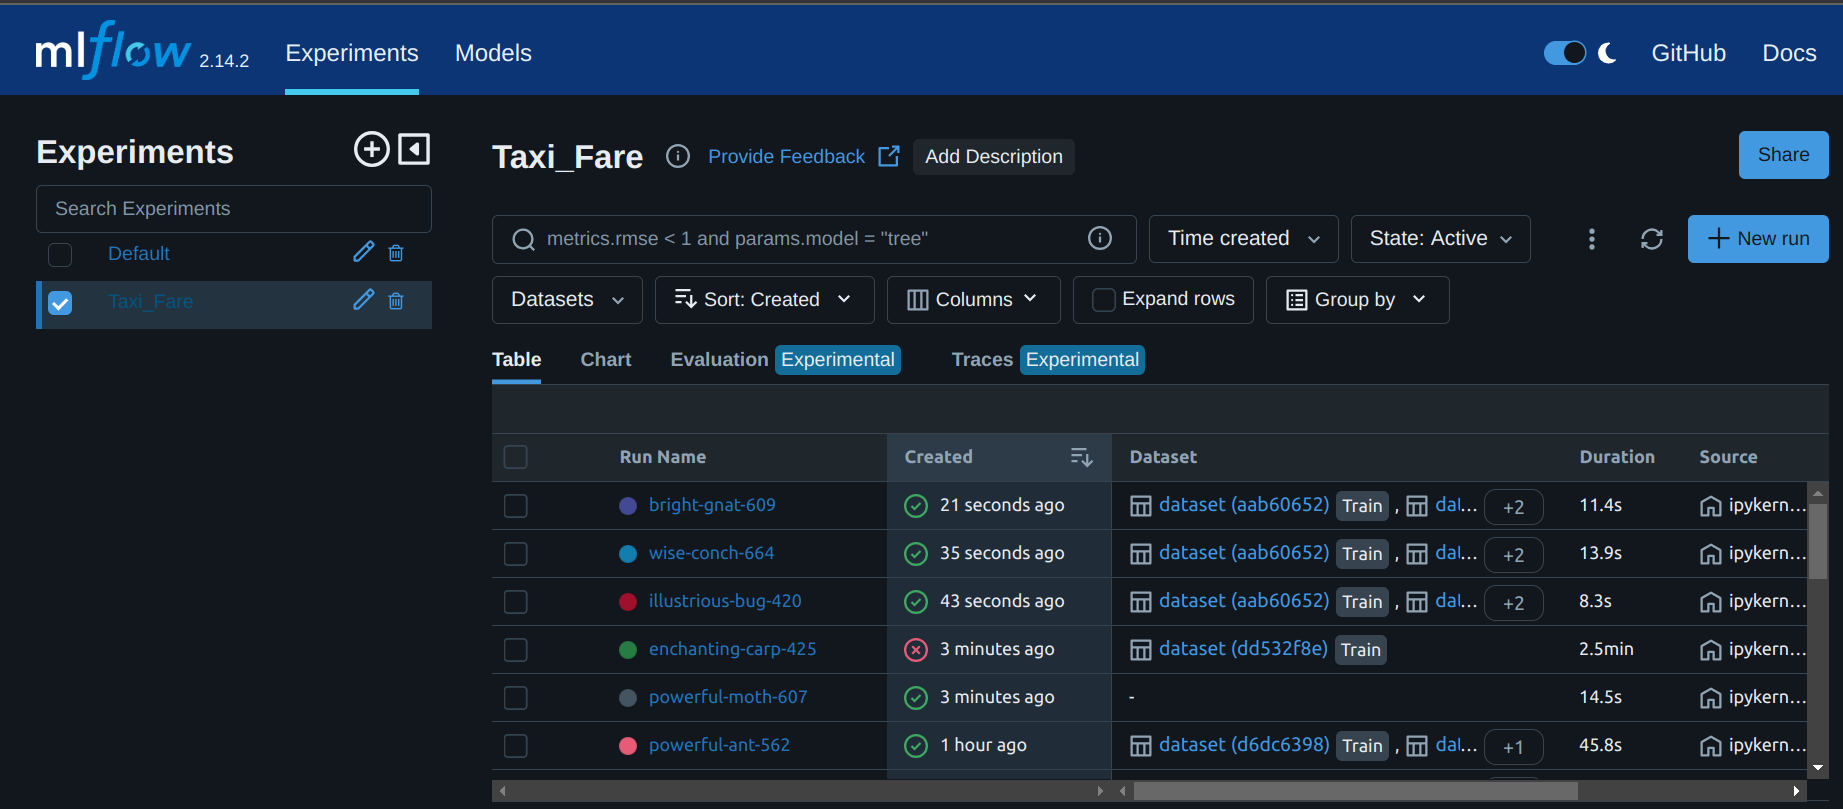

In [14]:
active_runs = (
    mlflow.search_runs(
        experiment_names=["Taxi_Fare"],
        # Select the best one with highest f1_score and test accuracy
        filter_string="metrics.RMSE < 1 ",
        search_all_experiments=True,
    )
    .sort_values(
        by=["metrics.RMSE"],
        ascending=False,
    )
    .reset_index()
    .loc[0]
)



artifact_path = json.loads(active_runs["tags.mlflow.log-model.history"])[0]["artifact_path"]
best_model_path = active_runs.artifact_uri + f"/{artifact_path}"

# Load the model as an MLflow PyFunc model
mlflow_model = mlflow.pyfunc.load_model(model_uri=best_model_path)

# Define the path to save the model
pickle_model_path = "./artifacts/models/Best_Model/"
if not os.path.exists(f"{pickle_model_path}"):
    os.makedirs(f"{pickle_model_path}", exist_ok=True)
    with open(pickle_model_path+"best_model.pkl", "wb") as file:
        pickle.dump(mlflow_model, file)
# Save the model
print(f"Model saved to {pickle_model_path}")




Model saved to ./artifacts/models/Best_Model/
